<a href="https://colab.research.google.com/github/Thanos2002/Easy-CNN-Digit-Classifier/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- In this example, we are using Google Collab, that already has pytorch and scipy installed.
In any other case it might be necessary to install them.
However, if you encounter an issue such as a missing package try installing the libraries manualy (e.g `!pip install torchvision`.)

In [167]:
import scipy
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

- The following code downloads the MNIST dataset from `torchvision.datasets` ,  into the `mnist` folder located in the root path.       

In [168]:
import torch
import torchvision.datasets as datasets
from google.colab import drive

# import additional libs in case not already done in 'askisi 1'
import matplotlib.pyplot as plt
import numpy as np

# Define the dataset directory
drive.mount('/content/drive')
path = '/content/gdrive/assignment/'

# Create the directory if it doesn't exist
# Load the MNIST training dataset
train_dataset = datasets.MNIST(root=path, train=True, download=True)

# Extract the images and labels from the training dataset
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()

# Load the MNIST testing dataset
test_dataset = datasets.MNIST(root=path, train=False, download=True)

# Extract the images and labels from the testing dataset
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Below, we display one random example image for each label (category) from the training data, corresponding to the categories, in order to examine the data that we are working with.

In [169]:
def plot_mnist_sample_high_res(X_train, y_train):
    """
    This function plots a sample image for each category,
    The result is a figure with 2x5 grid of images.

    """
    """ ==========
    YOUR CODE HERE
    ========== """

    plt.figure()

    for i in range(10):
        plt.subplot(2, 5, i+1)
        image = X_train[i]
        plt.title(f"Train: {y_train[i]} ")
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        plt.tight_layout()

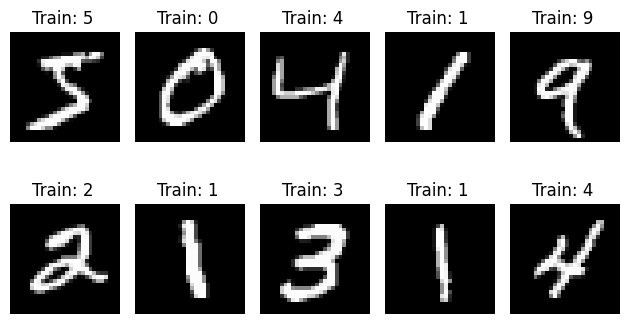

In [170]:
# PLOT CODE
plot_mnist_sample_high_res(X_train, y_train)

- **DataBatch** is a generator that yields batches of data and corresponding labels. It can optionally shuffle the data before yielding the batches. **Test** evaluates the classifier's accuracy on the test data.

In [171]:
def DataBatch(data, label, batchsize, shuffle=True):
    """
    This function provides a generator for batches of data that
    yields data (batchsize, 3, 32, 32) and labels (batchsize)
    if shuffle, it will load batches in a random order
    """
    n = data.shape[0]
    if shuffle:
        index = np.random.permutation(n)
    else:
        index = np.arange(n)
    for i in range(int(np.ceil(n/batchsize))):
        inds = index[i*batchsize : min(n,(i+1)*batchsize)]
        yield data[inds], label[inds]

def test(testData, testLabels, classifier):
    """
    Call this function to test the accuracy of a classifier
    """
    batchsize=50
    correct=0.
    for data,label in DataBatch(testData,testLabels,batchsize,shuffle=False):
        prediction = classifier(data)
        correct += np.sum(prediction==label)
    return correct/testData.shape[0]*100

- This code defines a base class for our deep neural network (`DNN`) in PyTorch. It provides a foundation for building and training custom neural networks by implementing a training loop (`train_net`). The class includes methods for initializing the network, performing forward passes, and training the network using stochastic gradient descent and cross-entropy loss.

In [172]:
# base class for your deep neural networks. It implements the training loop (train_net).
import torch.nn.init
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from tqdm import tqdm
from scipy.stats import truncnorm

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        pass

    def forward(self, x):
        raise NotImplementedError

    def train_net(self, X_train, y_train, epochs=1, batchSize=50):

        # criterion selection, i.e, loss function
        criterion = nn.CrossEntropyLoss()
        # optimizer selection, using `optim.`
        optimizer = optim.SGD(self.parameters(),lr=0.01)
        losses = []
        # For each epoch
        for epoch in range(epochs):
          sum_loss = 0.0
          # For each batch
          for i in tqdm(range(0, len(X_train), batchSize)):
          #for i , batch in enumerate(X_train,0):
              # Assign inputs and labels using PyTorch's autograd package via Variable
              inputs = Variable(torch.FloatTensor(X_train[i:i+batchSize]))
              labels = Variable(torch.LongTensor(y_train[i:i+batchSize]))
              # Forward pass
              optimizer.zero_grad()
              outputs = self.forward(inputs)
              # Compute loss
              loss = criterion(outputs, labels)
              # Backward pass
              loss.backward()
              # Weight update
              optimizer.step()
              # Final loss
              losses.append(loss.item())
              sum_loss += loss.item()

          print(f"Epoch {epoch + 1}, Loss: {sum_loss / (len(X_train) // batchSize)}")

    def __call__(self, x):
        inputs = Variable(torch.FloatTensor(x))
        prediction = self.forward(inputs)
        return np.argmax(prediction.data.cpu().numpy(), 1)


Bellow is the implementaion of the CNN classifier:


*   n=10 (output features or filters)
*   Leaky_ReLU( Conv(kernel_size=5x5, stride=2, output_features=n) )
*   Leaky_ReLU( Conv(kernel_size=5x5, stride=2, output_features=n*2) )
*   Leaky_ReLU( Linear(hidden units = 64) )
*   Linear(output_features=classes)

Two convolutional layers (Conv Layers) that map the input of the previous layer non-linearly (ReLU), followed by 1 fully connected hidden layer (FC hidden layer) with non-linear activation (ReLU), and then the output layer, which combines linearly the values of the previous layer.






In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sn

# Defining a Convolutional Neural Network
class CNNClassifier(DNN):
    def __init__(self, classes=10, n=10):
        super(CNNClassifier, self).__init__()
        """
        Initialization of the CNN layers using torch.nn.Conv2d and torch.nn.Linear
        """
        # First Convolutional Layer:
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n, kernel_size=5, stride=2, padding=2)

        # Second Convolutional Layer:
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=5, stride=2, padding=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(2 * n * 7 * 7, 64)  # Flattened input size from second conv layer to 64 neurons
        self.fc2 = nn.Linear(64, classes)        # From 64 neurons to number of classes (e.g., 10 for MNIST)

    def forward(self, x):
        """
        Forward pass of the CNNClassifier
        """
        # Reshape input to match the expected dimensions for Conv2d: (batch_size, channels, height, width)
        x = x.view(x.size(0), 1, 28, 28)

        # Apply first convolutional layer followed by ReLU activation
        x = F.leaky_relu(self.conv1(x))  # Output: (batch_size, n, 14, 14)

        # Apply second convolutional layer followed by ReLU activation
        x = F.leaky_relu(self.conv2(x))  # Output: (batch_size, 2*n, 7, 7)

        # Flatten the output of the second convolutional layer
        x = x.view(x.size(0), -1)

        # Apply the first fully connected layer followed by ReLU activation
        x = F.leaky_relu(self.fc1(x))    # Output: (batch_size, 64)

        # Apply the second fully connected layer for the final output
        x = self.fc2(x)            # Output: (batch_size, number of classes)
        self.y = x

        return x

X_train = np.float32(X_train) / 255.0
X_train = X_train.reshape(-1, 1, 28, 28)

X_test = np.float32(X_test) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28)


In [174]:
# Instantiate and train the model
cnnClassifier = CNNClassifier()
cnnClassifier.train_net(X_train, y_train, epochs=10, batchSize=50)

100%|██████████| 1200/1200 [00:10<00:00, 116.58it/s]


Epoch 1, Loss: 1.736793552832678


100%|██████████| 1200/1200 [00:10<00:00, 116.05it/s]


Epoch 2, Loss: 0.3553081815224141


100%|██████████| 1200/1200 [00:09<00:00, 132.38it/s]


Epoch 3, Loss: 0.2525371808356916


100%|██████████| 1200/1200 [00:11<00:00, 104.48it/s]


Epoch 4, Loss: 0.19290832174010575


100%|██████████| 1200/1200 [00:10<00:00, 115.67it/s]


Epoch 5, Loss: 0.1571121386407564


100%|██████████| 1200/1200 [00:10<00:00, 115.13it/s]


Epoch 6, Loss: 0.13294834939956976


100%|██████████| 1200/1200 [00:09<00:00, 128.99it/s]


Epoch 7, Loss: 0.11531821783438015


100%|██████████| 1200/1200 [00:10<00:00, 118.49it/s]


Epoch 8, Loss: 0.10201699481500934


100%|██████████| 1200/1200 [00:10<00:00, 119.57it/s]


Epoch 9, Loss: 0.09164865892593904


100%|██████████| 1200/1200 [00:08<00:00, 137.75it/s]

Epoch 10, Loss: 0.08330837088753469


In [175]:
# Check also standard accucary of test() for consistency
print ('CNN classifier accuracy: %f'%test(X_test, y_test, cnnClassifier))

CNN classifier accuracy: 97.290000


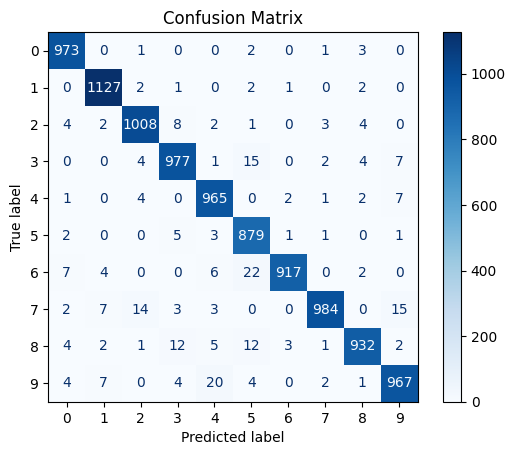

In [176]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = cnnClassifier(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

 - **Test** the model with specific digit images. You can load images to the path, in order to see the classifier "working". You can preprocess the image with **load_digit_image()** for best results.

In [177]:
from PIL import Image
import numpy as np
import torch

def load_digit_image(file_path):
    """
    Load and preprocess a digit image from a file.
    """
    # Load the image
    img = Image.open(file_path).convert('L')  # Convert to grayscale
    # Invert colors if necessary (white digits on black background)
    image = Image.fromarray(255 - np.array(img))
    # Resize to 28x28 pixels
    img = img.resize((28, 28))

    # Convert to numpy array and normalize
    img_array = np.array(img, dtype=np.float32) / 255.0

    # Reshape to (1, 1, 28, 28) for PyTorch
    img_tensor = torch.tensor(img_array).unsqueeze(0).unsqueeze(0)

    return img_tensor


In [201]:
prediction = cnnClassifier(load_digit_image('/content/Ds5Rc.png'))
if(prediction == 3):
  print("True")
else:
  print("False")


True
